# generating toy data for calorimeter studies with autoencoders

In this notebook, we will generate a very rough approximation of the HGCAL.  To keep things simple, a rectangular geometry will be assumed.  The basic features will be $n$ layers with each layer being an $m\times m$ grid of sensor cells.  The showering will be generated by discretizing a multivariatie normal distribution within the 3d grid with some small amount of noise in each cell.  The location and covariance of the will also random variation, but will tend to favor certain correlations as in the case of physical showering.

In [1]:
## imports and configuration
%cd '/home/naodell/work/hgcal/analysis'
#%load_ext autoreload

from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gamma
#import h5py

from tqdm.notebook import tqdm

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/hgcal/analysis
{
  "shell_port": 50811,
  "iopub_port": 36497,
  "stdin_port": 40981,
  "control_port": 40163,
  "hb_port": 40607,
  "ip": "127.0.0.1",
  "key": "1ea24c0c-232d71b9c1b8522aca38b6ba",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-fbec216e-e37a-46bf-abf6-8baa8cfb7607.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# define geometry
pos_ip = np.array([0., 0., 0.]) # position of origin
ncells = np.array([16, 16, 5]) # number of cells for each dimension
det_face_loc = np.array([0, 0, 10])

In [3]:
# generate events
rng = np.random
nsamples = int(1e6)
xsize, ysize = ncells[0], ncells[1]
samples = []
energy_sum = []
for _ in tqdm(range(nsamples)):
    nhits = 1 + rng.poisson(2)
    mu_rand = rng.randint(0, ncells[0], 2*nhits).reshape(nhits, 2)
    np.random.randn(nhits)
    
    # initialize grid with poisson noise and generate energy from n sources. Quantize into cells
    ienergy = np.zeros(xsize, ysize) 
    for _ in range(nhits):
        #e = rng.randn(2, rng.randint(5000, 10000))
        e = (0.5*rng.rand() + 0.5)*rng.randn(2, 1000)
        dx, dy = rng.randint(2, xsize-1)+0.5, rng.randint(1, ysize-1)+0.5
        #xy_energy.append([dx, dy])
        ie, _, _ = np.histogram2d(e[0]+dx, e[1]+dy,
                                  bins=[xsize, ysize], 
                                  range=((0, xsize), (0, ysize))
                                 )
        ienergy = ienergy + (1 + 2*rng.rand())*ie

    samples.append(ienergy/ienergy.sum())
    energy_sum.append(ienergy.sum())
    
samples = np.array(samples)
energy_sum = np.array(energy_sum)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [4]:
# save output
#f = h5py.File('data/toy_data.hdf5', 'w')
#d1 = f.create_dataset('toy_data', data=samples)
#d22 = f.create_dataset('toy_data_flat', data=samples_flat)

f = open('local_data/toy_data.pkl', 'wb')
pickle.dump(samples, f)
pickle.dump(energy_sum, f)
f.close()

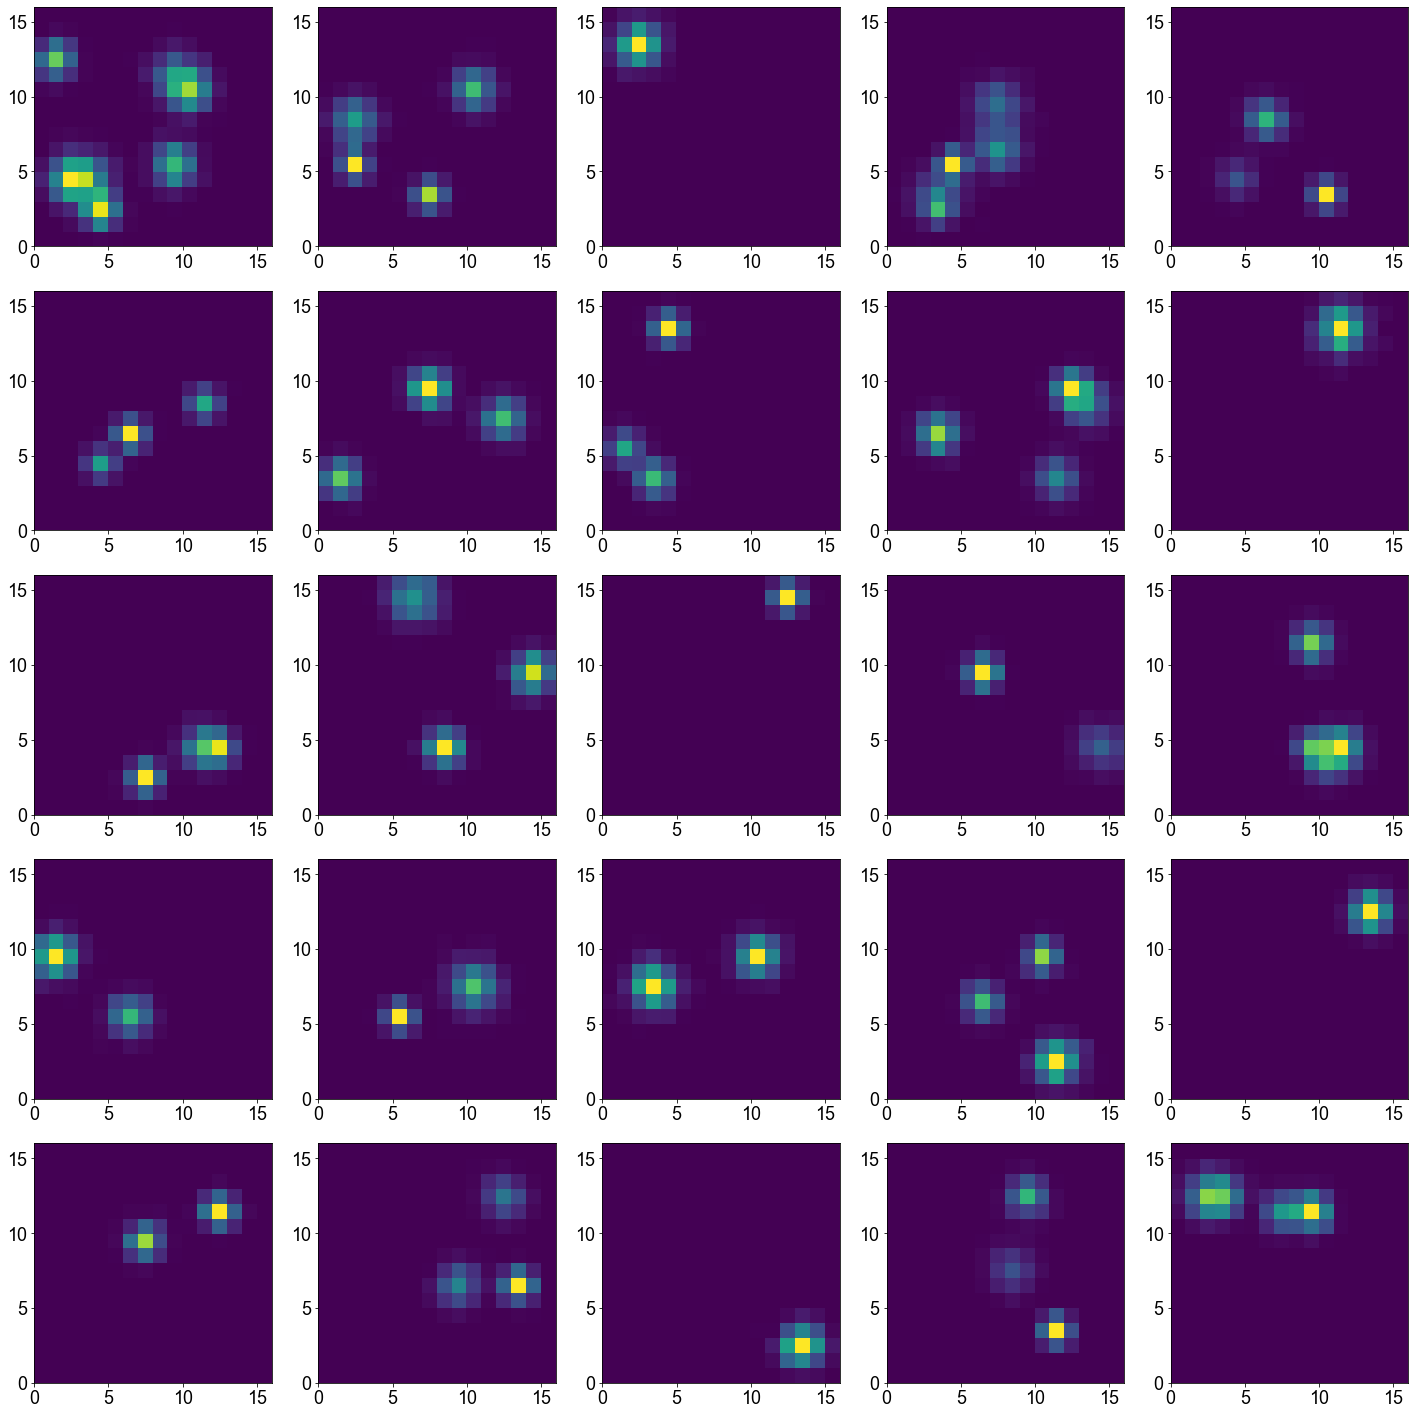

In [5]:
# test plot
fig, axes = plt.subplots(5, 5, figsize=(20, 20), facecolor='white')

for i, sample in enumerate(samples[:25]):
    ax = axes[i%5][i//5]
    ax.pcolor(sample)
    
plt.tight_layout()
plt.show()